<a href="https://colab.research.google.com/github/duypham01/PDENet/blob/main/BlackScholes_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import time
import json

In [ ]:
# Generate Data
T = 1
interval = 50
delta_t = T/interval
# num_sample = 400
dim = 100
sigma = 0.2
rate = 0.02   # interest rate R
delta = 2.0 / 3
gammah = 0.2
gammal = 0.02
mu_bar = 0.02
vh = 50.0
vl = 70.0
slope = (gammah - gammal) / (vh - vl)
num_hiddens = [110, 110]
DELTA_CLIP = 50.0
def generateData(num_sample):
    x_0 = np.ones(dim) * 100.0
    delta_W = np.random.normal(size=[num_sample, dim, interval]) * np.sqrt(delta_t) # ~= N(0,delta_t)
    X = np.zeros([num_sample, dim, interval + 1])
    X[:, :, 0] = np.ones([num_sample, dim]) * x_0
    for i in range(interval):
        X[:, :, i + 1] = (1 + mu_bar * delta_t) * X[:, :, i] + (
            sigma * X[:, :, i] * delta_W[:, :, i])
    return X.astype('float32'), delta_W.astype('float32')

In [ ]:
def f(t,y):
    piecewise_linear = tf.nn.relu(
            tf.nn.relu(y - vh) * slope + gammah - gammal) + gammal
    return (-(1 - delta) * piecewise_linear - rate) * y

def g(t,x):
    return tf.reduce_min(x, 1, keepdims=True)

class Subnet(tf.keras.Model):
    def __init__(self):
        super(Subnet, self).__init__()
        # self.layers = [
        #     tf.keras.layers.BatchNormalization(
        #         momentum=0.99,
        #         epsilon=1e-6,
        #         beta_initializer=tf.random_normal_initializer(0.0, stddev=0.1),
        #         gamma_initializer=tf.random_uniform_initializer(0.1, 0.5)
        #     )
        #     for _ in range(len(num_hiddens) + 2)]
        self.h_layers = [tf.keras.layers.Dense(num_hiddens[i],
                                                   use_bias=True,
                                                   activation='relu', dtype='float32')
                             for i in range(len(num_hiddens))]
        # final output should be gradient of size dim
        self.f_layers=tf.keras.layers.Dense(dim, activation=None, dtype='float32')

    def call(self, x):
        """structure: bn -> (dense -> bn -> relu) * len(num_hiddens) -> dense -> bn"""
        # x = self.bn_layers[0](x, training)
        for i in range(len(self.h_layers)):
            x = self.h_layers[i](x)
            # x = self.bn_layers[i+1](x, training)
            # x = tf.nn.relu(x)
        x = self.f_layers(x)
        # x = self.bn_layers[-1](x, training)
        return x
class BlackScholesModel(tf.keras.Model):
    def __init__(self):
        super(BlackScholesModel, self).__init__()
        self.y_0 = tf.Variable(np.random.uniform(low=40,high=50,size=[1]), dtype='float32')
        self.z_0 = tf.Variable(np.random.uniform(low=-.1, high=.1,size=[1, dim]), dtype='float32')
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=8e-3, epsilon=1e-8)
        self.training_history = []
        self.subnet = [Subnet() for _ in range(interval-1)]
    def call(self, X, delta_W):
        # X, delta_W = inputs
        time_stamp = np.arange(0, interval) * delta_t
        all_one_vec = tf.ones(shape=tf.stack([tf.shape(delta_W)[0], 1]), dtype="float32")
        # print(all_one_vec.shape)
        # print(self.y_0.shape)
        y = all_one_vec * self.y_0
        z = tf.matmul(all_one_vec, self.z_0)

        for t in range(0, interval-1):
            y = y - delta_t * (
                f(time_stamp[t], y)
            ) + tf.reduce_sum(z * delta_W[:, :, t], 1, keepdims=True)
            z = self.subnet[t](X[:, :, t + 1]) / dim
        # terminal time
        y = y - delta_t * f(time_stamp[-1], y) + \
            tf.reduce_sum(z * delta_W[:, :, -1], 1, keepdims=True)
        return y
    def train(self, num_iterations):
        start_time = time.time()
        # valid_data = self.bsde.sample(256)

        # begin sgd iteration
        for step in range(num_iterations+1):  
            # self.train_step(self.bsde.sample(self.net_config.batch_size))
            # Loss
            with tf.GradientTape(persistent=True) as tape:
                # X, delta_W = data
                X, delta_W = generateData(64)
                y_terminal = self.call(X, delta_W)
                delta = y_terminal - g(T, X[:, :, -1])
                # use linear approximation outside the clipped range
                loss = tf.reduce_mean(tf.where(tf.abs(delta) < DELTA_CLIP, tf.square(delta),
                                            2 * DELTA_CLIP * tf.abs(delta) - DELTA_CLIP ** 2))
            grad = tape.gradient(loss, self.trainable_variables)
            del tape
            if step % 100 == 0:
                p_loss = loss.numpy()
                y_0 = self.y_0.numpy()[0]
                elapsed_time = time.time() - start_time
                self.training_history.append([step, p_loss, y_0, elapsed_time])
                print("step: %5u,    loss: %.4e, Y0: %.4e,   elapsed time: %3u" % (
                        step, p_loss, y_0, elapsed_time))
            self.optimizer.apply_gradients(zip(grad, self.trainable_variables))


In [ ]:
# X, delta_W = generateData()
PDEModel = BlackScholesModel()
PDEModel.train(num_iterations=6000)

step:     0,    loss: 2.7663e+02, Y0: 4.2737e+01,   elapsed time:   0
step:   100,    loss: 1.5919e+02, Y0: 4.3530e+01,   elapsed time:  48
step:   200,    loss: 1.9267e+02, Y0: 4.4302e+01,   elapsed time:  85
step:   300,    loss: 1.5720e+02, Y0: 4.5044e+01,   elapsed time: 122
step:   400,    loss: 1.2954e+02, Y0: 4.5758e+01,   elapsed time: 158
step:   500,    loss: 1.2193e+02, Y0: 4.6440e+01,   elapsed time: 194
step:   600,    loss: 1.0819e+02, Y0: 4.7090e+01,   elapsed time: 230
step:   700,    loss: 9.3346e+01, Y0: 4.7705e+01,   elapsed time: 265
step:   800,    loss: 8.5763e+01, Y0: 4.8289e+01,   elapsed time: 307
step:   900,    loss: 7.3485e+01, Y0: 4.8849e+01,   elapsed time: 343
step:  1000,    loss: 9.0006e+01, Y0: 4.9374e+01,   elapsed time: 378
step:  1100,    loss: 5.3673e+01, Y0: 4.9885e+01,   elapsed time: 414
step:  1200,    loss: 7.1135e+01, Y0: 5.0371e+01,   elapsed time: 449
step:  1300,    loss: 5.9252e+01, Y0: 5.0849e+01,   elapsed time: 486
step:  1400,    loss

In [ ]:
training_history = PDEModel.training_history

Text(0, 0.5, 'Y0')

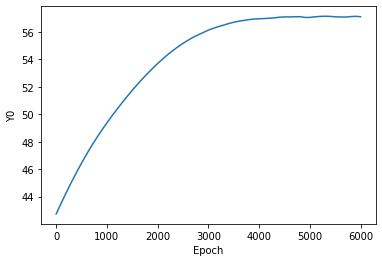

In [ ]:
import matplotlib.pyplot as plt
y0_arr = [item[2] for item in training_history]
step_arr = [item[0] for item in training_history]
plt.plot(step_arr, y0_arr)
plt.xlabel('Epoch')
plt.ylabel('Y0')